In [161]:
import dependencies
import line_profiler
import numpy as np
from scipy.stats import wishart, invwishart

from Scripts.generate_data import generate_Ys
from Scripts.scBiGLasso import analyticBiGLasso
from Scripts.utilities import generate_confusion_matrices
from Scripts.utilities import precision, recall, accuracy
from Scripts.niBiGLasso import niBiGLasso

np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
# Standard way to generate matrix variate data, takes ~1 second
Psi_gen, Theta_gen, Ys = generate_Ys(
    m=100, # Note that we only need m=3 for good vindication, whereas
    p=(p:=100), # m needs to be much larger to get good estimates in general
    n=(n:=100), # anyways (in this alg and scalable version).
    expected_nonzero_psi=n**2 / 5, # (divide by 5 for sparsity)
    expected_nonzero_theta=p**2 / 5,
    structure="Kronecker Sum",
    posdef_distr=invwishart
)
Ys.shape

(100, 100, 100)

In [181]:
nibig = niBiGLasso()
T_psi, T_theta = nibig.get_empiricals(Ys)
nibig.fit(T_psi, T_theta)
Psi, Theta = nibig.shrink(0.07, 0.07)#0.02, 0.02
nibig.print_vindication()
print("===Psi===")
print(Psi_cm := generate_confusion_matrices(Psi, Psi_gen, mode='Negative'))
print(
    f"{precision(Psi_cm)=:.3f}",
    f"\n{recall(Psi_cm)=:.3f}",
    f"\n{accuracy(Psi_cm)=:.3f}"
)
print("\n==Theta==")
print(Theta_cm := generate_confusion_matrices(Theta, Theta_gen, mode='Negative'))
print(
    f"{precision(Theta_cm)=:.3f}",
    f"\n{recall(Theta_cm)=:.3f}",
    f"\n{accuracy(Theta_cm)=:.3f}"
)

Psi vindication: 0.9995495242353498
Theta vindication: 0.9993306340969997
===Psi===
[[1054.    0.]
 [  52. 8794.]]
precision(Psi_cm)=1.000 
recall(Psi_cm)=0.953 
accuracy(Psi_cm)=0.995

==Theta==
[[1168.    0.]
 [  88. 8644.]]
precision(Theta_cm)=1.000 
recall(Theta_cm)=0.930 
accuracy(Theta_cm)=0.991


In [13]:
# Investigate runtime
from Scripts.niBiGLasso import no_hassle
nibig = niBiGLasso()
kwargs = {
    "Ys": Ys,
    "beta_1": 0.02,
    "beta_2": 0.02,
    "vindicate": False, # Takes 90% of the runtime if true!
    "nibig": nibig
}
%lprun -f no_hassle -f nibig.get_empiricals -f nibig.fit no_hassle(**kwargs)

Typical output of the runtime calculation:
```
Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   205                                           def no_hassle(Ys, beta_1, beta_2, vindicate=True, nibig=None):
   206         1          3.0      3.0      0.0      if nibig is None:
   207                                                   nibig = niBiGLasso()
   208         1      72803.0  72803.0     65.2      T_psi, T_theta = nibig.get_empiricals(Ys)
   209         1      12624.0  12624.0     11.3      nibig.fit(T_psi, T_theta)
   210         1      26233.0  26233.0     23.5      Psi, Theta = nibig.shrink(beta_1, beta_2)
   211         1          0.0      0.0      0.0      if vindicate:
   212                                                   vinds = nibig.vindicate()
   213                                               else:
   214         1          0.0      0.0      0.0          vinds = None
   215         1          0.0      0.0      0.0      return Psi, Theta, vinds
```

# Extra Stuff

In [173]:
# Note the inverse of the empirical covariance matrix
# are great estimators of our precision matrix, as
# we would expect - so why don't we use these???
T_psi, T_theta = nibig.get_empiricals(Ys)
nibig.Psi = np.linalg.inv(T_psi)
nibig.Theta = np.linalg.inv(T_theta)
Psi, Theta = nibig.shrink(0.07, 0.07)
print("===Psi===")
print(Psi_cm := generate_confusion_matrices(Psi, Psi_gen, mode='Negative'))
print(
    f"{precision(Psi_cm)=:.3f}",
    f"\n{recall(Psi_cm)=:.3f}",
    f"\n{accuracy(Psi_cm)=:.3f}"
)
print("\n==Theta==")
print(Theta_cm := generate_confusion_matrices(Theta, Theta_gen, mode='Negative'))
print(
    f"{precision(Theta_cm)=:.3f}",
    f"\n{recall(Theta_cm)=:.3f}",
    f"\n{accuracy(Theta_cm)=:.3f}"
)

===Psi===
[[ 874.    2.]
 [ 130. 8894.]]
precision(Psi_cm)=0.998 
recall(Psi_cm)=0.871 
accuracy(Psi_cm)=0.987

==Theta==
[[ 820.   20.]
 [ 190. 8870.]]
precision(Theta_cm)=0.976 
recall(Theta_cm)=0.812 
accuracy(Theta_cm)=0.979


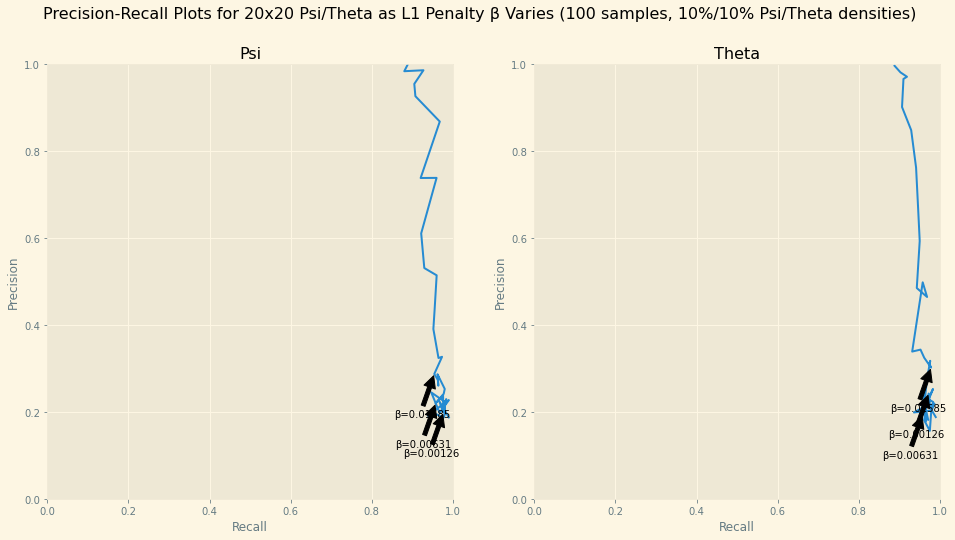

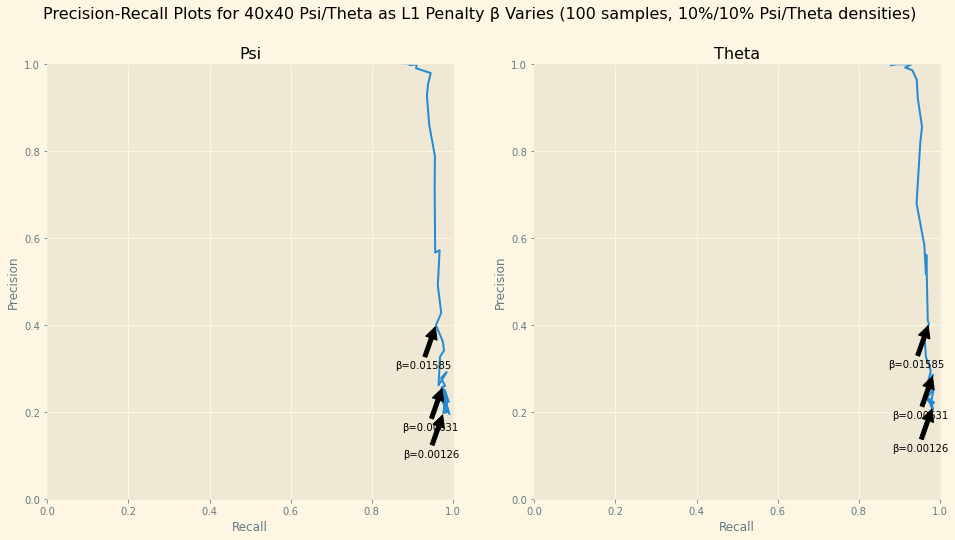

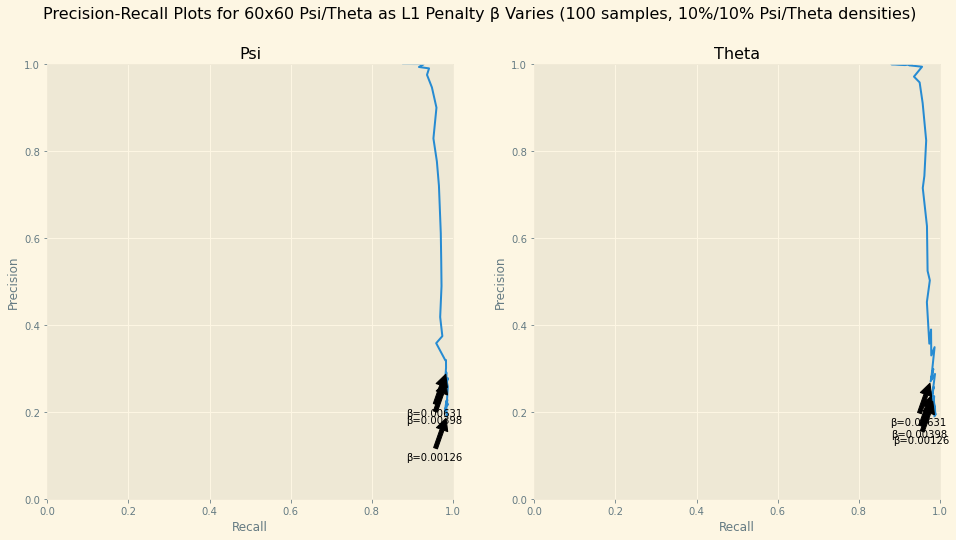

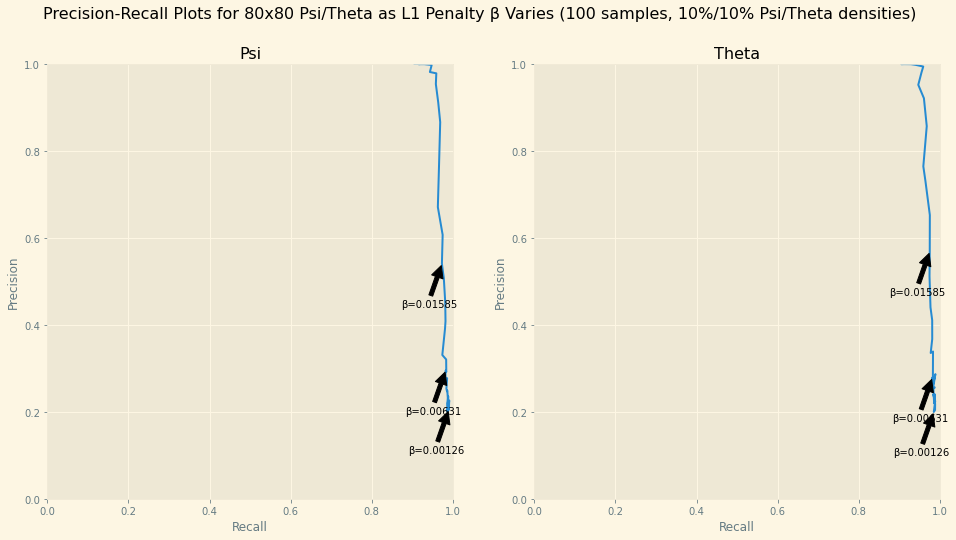

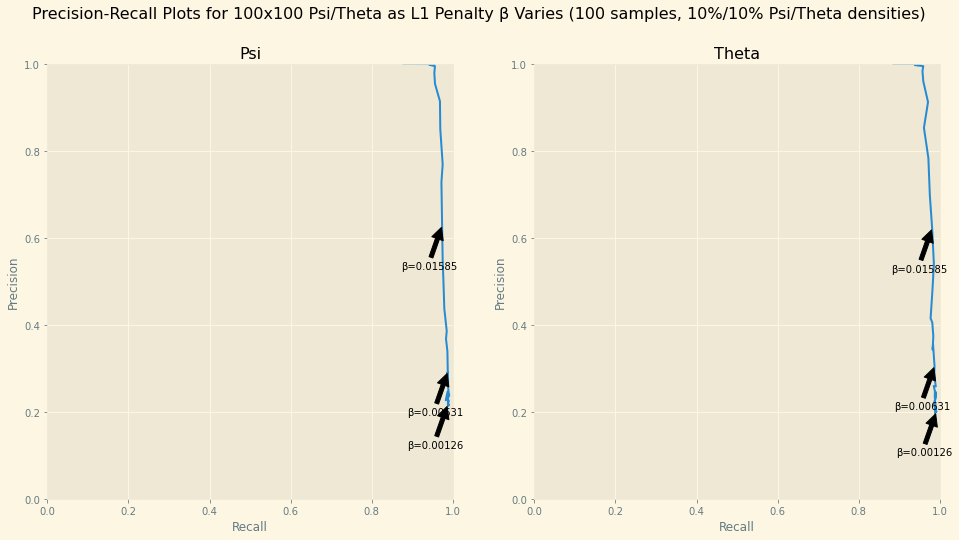

In [71]:
from Scripts.experiments import analytic_create_precision_recall_curves
import matplotlib.pyplot as plt
# How does choice of betas and matrix size affect results?
sizes = [20, 40, 60, 80, 100]
betas = [
    10**np.arange(-3, -1, 0.05), # 20
    10**np.arange(-3, -1, 0.05), # 40
    10**np.arange(-3, -1, 0.05), # 60
    10**np.arange(-3, -1, 0.05), # 80
    10**np.arange(-3, -1, 0.05) # 100
]
interesting_indices = [
    [2, 16, 24],
    [2, 16, 24],
    [2, 12, 16],
    [2, 16, 24],
    [2, 16, 24]
]
for idx, size in enumerate(sizes):
    fig, axs, dicts = analytic_create_precision_recall_curves(
        betas[idx],
        100,
        size,
        attempts=25,
        indices_to_highlight=interesting_indices[idx],
        verbose=False
    )
    display(fig) # Force figure to display NOW (`fig.show()` does not do this)
    plt.close(fig) # Suppress double-displaying the figure


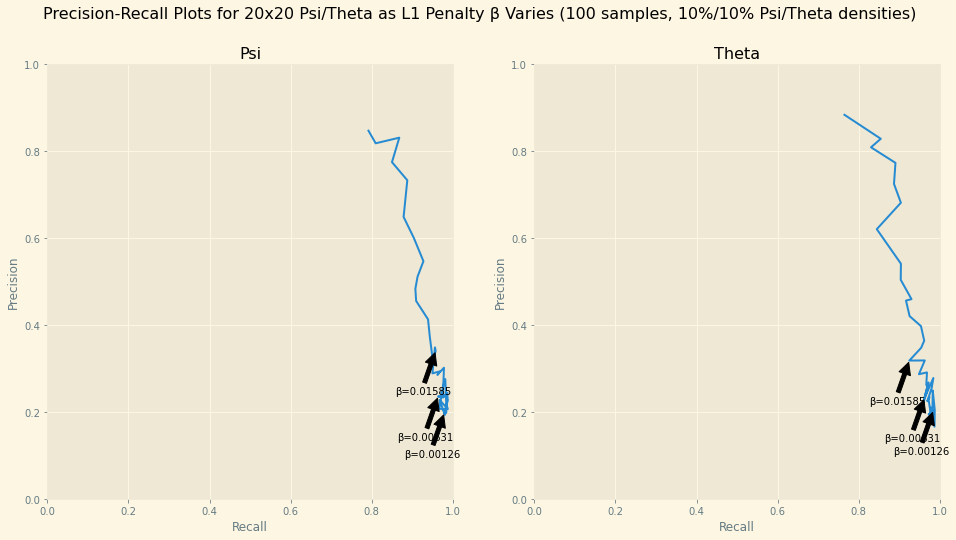

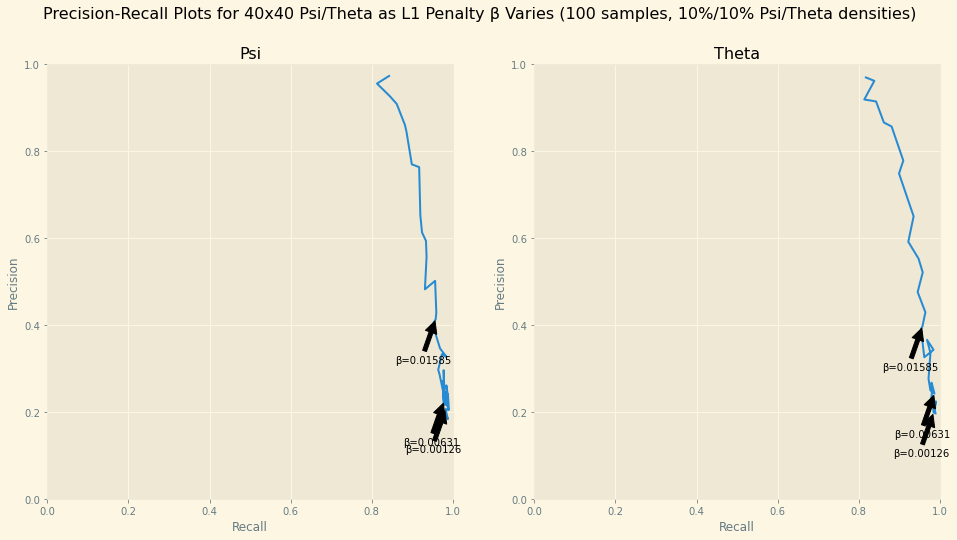

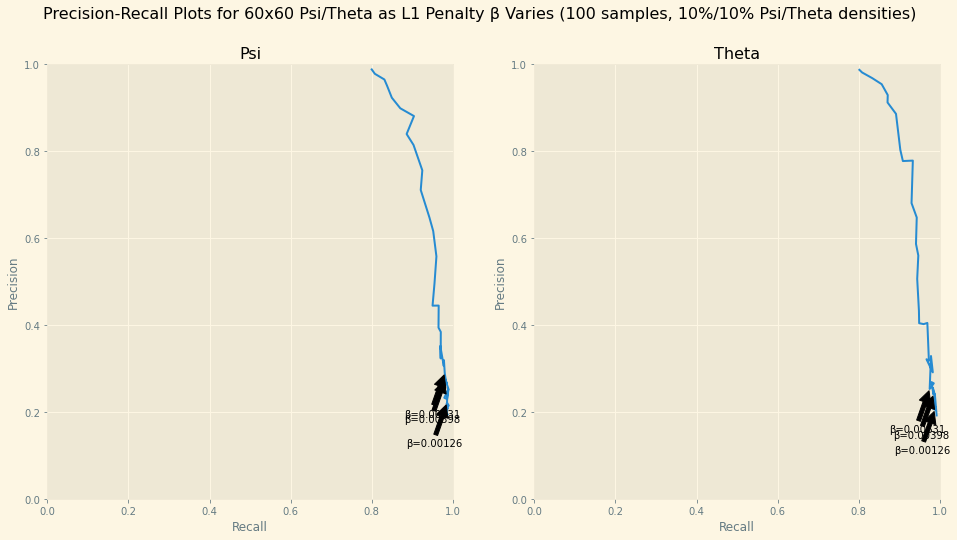

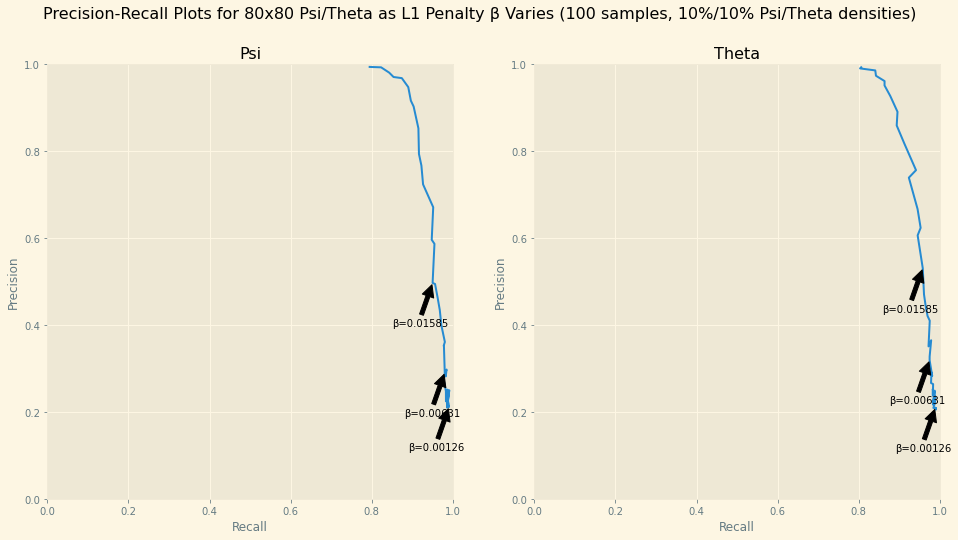

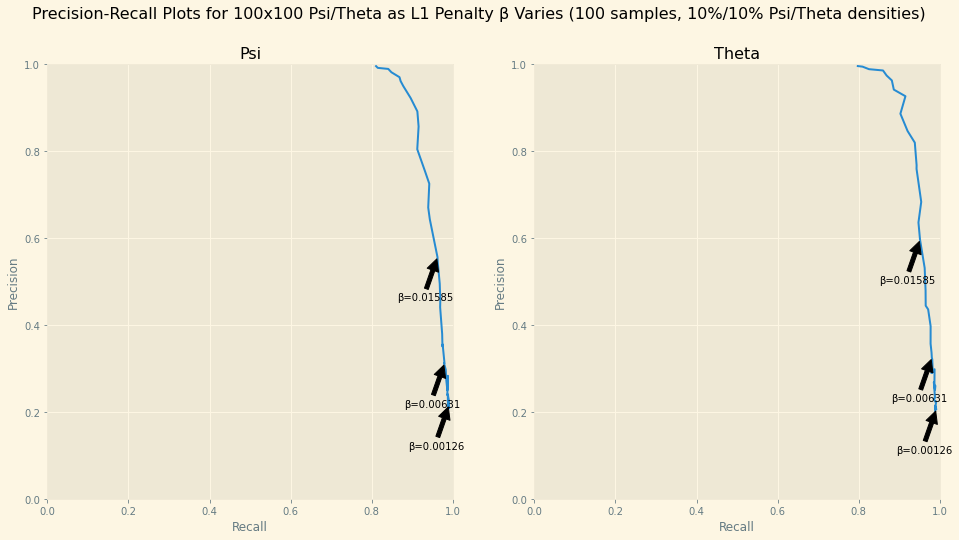

In [147]:
from Scripts.experiments import inverse_trick_create_precision_recall_curves
# How does choice of betas and matrix size affect results?
sizes = [20, 40, 60, 80, 100]
betas = [
    10**np.arange(-3, -1, 0.05), # 20
    10**np.arange(-3, -1, 0.05), # 40
    10**np.arange(-3, -1, 0.05), # 60
    10**np.arange(-3, -1, 0.05), # 80
    10**np.arange(-3, -1, 0.05) # 100
]
interesting_indices = [
    [2, 16, 24],
    [2, 16, 24],
    [2, 12, 16],
    [2, 16, 24],
    [2, 16, 24]
]
for idx, size in enumerate(sizes):
    fig, axs, dicts = inverse_trick_create_precision_recall_curves(
        betas[idx],
        100,
        size,
        attempts=25,
        indices_to_highlight=interesting_indices[idx],
        verbose=False
    )
    display(fig) # Force figure to display NOW (`fig.show()` does not do this)
    plt.close(fig) # Suppress double-displaying the figure


In [157]:
# Empirically verify lemma 2
from Scripts.utilities import tr_p, kron_prod
q, Q = np.linalg.eig(Psi_gen)
W = np.random.random((Psi_gen.shape[0]*2, Psi_gen.shape[1]*2))
U = np.eye(2)
#print(Q @ tr_p(W, p=2) @ Q.T)
#print(tr_p(kron_prod(Q, U) @ W @ kron_prod(Q, U).T, p=2))
print(tr_p(kron_prod(Q, np.eye(2)) @ W, p=2))
print(tr_p(W @ kron_prod(Q, np.eye(2)), p=2))
print(tr_p(kron_prod(np.eye(2), Q) @ W, p=2))
print(tr_p(W @ kron_prod(np.eye(2), Q), p=2))
print(np.trace(W[:2, :2] @ Q[:2, :2]))
print(np.trace(Q[:2, :2] @ W[:2, :2]))

[[ 0.922  1.545  0.353 ...  0.813  1.008  1.37 ]
 [-2.123 -1.461 -1.623 ... -0.787 -0.904 -1.072]
 [ 1.41   0.832  0.852 ...  0.359  0.927  1.475]
 ...
 [-1.275 -1.171 -1.792 ... -1.415 -1.023 -1.824]
 [ 0.891  1.829  1.121 ...  0.683  0.827  1.675]
 [ 0.276  0.817  1.288 ...  0.67   1.317  1.25 ]]
[[ 1.213  1.293 -0.399 ...  1.711  0.748  1.399]
 [ 1.293  0.708 -0.651 ...  0.184  1.801  1.674]
 [ 1.568  1.252 -0.481 ...  0.679  0.943  1.092]
 ...
 [ 0.543  0.291 -1.418 ...  0.564  1.106  0.926]
 [ 1.042  1.261  0.087 ...  1.203  0.827  1.675]
 [ 0.82   0.6   -0.615 ...  1.094  1.317  1.25 ]]
[[ 0.431 -0.066 -0.448 ... -0.14   0.221  0.116]
 [ 0.546  1.184  0.983 ...  1.69   1.112  0.925]
 [ 0.8    0.973  0.609 ...  0.897  0.583 -0.356]
 ...
 [ 1.079  0.964  1.185 ...  0.105  0.215  1.466]
 [-0.263 -0.72   0.424 ... -0.255 -0.538 -0.221]
 [ 0.276  0.817  1.288 ...  0.67   1.317  1.25 ]]
[[ 0.692 -0.188 -1.234 ...  1.711  0.869  1.399]
 [ 0.347 -0.525 -1.964 ...  0.184  1.444  1.674]
 [